In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import csv
import matplotlib.pyplot as plt

import keras
# import tensorflow as tf
import csv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [26]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Data Pr-processing PipeLine

In [0]:
from keras import layers
from keras import models
import tensorflow as tf
import h5py

In [0]:
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

def load_dataset():
    '''
    Load training dataset
    '''
    Xtrain = []
    Ytrain = []
    # open the csv as a object
    with open('/gdrive/My Drive/all/training.csv') as csvfile:
        # create a csv object.
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            # ----------
            # initialization
            Yitem = []
            failed = False
            # -------------------
            for coord in row:
                # loops through the keys present in individual row.
                # print(coord)
                if coord == "Image":
                    continue
                # this condition takes care of missing values.
                if(row[coord].strip()==""):
                    failed = True
                    break
                Yitem.append(float(row[coord]))
            if not failed:
                Xtrain.append(img)
                Ytrain.append(Yitem)
                
                
    return np.array(Xtrain), np.array(Ytrain, dtype=np.float)

# print(load_dataset())

In [0]:
Xdata, Ydata = load_dataset()
Xtrain = Xdata[:]
Ytrain = Ydata[:]

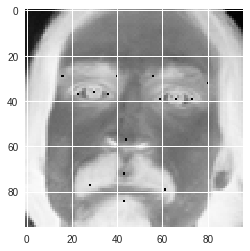

In [41]:
def show_image(X, Y):
    img = np.copy(X)
    for i in range(0,Y.shape[0] , 2):
#         print(Y)
#         print("*****************")
#         print(Y[i+1] , Y[i])
        if 0 < Y[i+1] < IMAGE_HEIGHT and 0 < Y[i] < IMAGE_WIDTH:
            img[int(Y[i+1]),int(Y[i]),0] = 255
    plt.imshow(img[:,:,0])
    
show_image(Xtrain[0], Ytrain[0])

In [0]:
Ytrain[51]

array([65.81543662, 35.0796169 , 31.07019718, 36.28813521, 60.07504225,
       35.38174648, 71.55650704, 35.0796169 , 37.11278873, 37.19452394,
       24.42321127, 36.59026479, 57.35594366, 29.6411493 , 74.57780282,
       28.13050141, 40.13408451, 28.73476056, 19.89092958, 32.3603831 ,
       47.98985915, 55.92676056, 64.60732394, 70.73171831, 34.69588732,
       71.6376338 , 49.50016901, 70.12732394, 49.8023662 , 79.79560563])

## RESNET 

[RESNET Architecture](https://gist.github.com/mjdietzx/0cb95922aac14d446a6530f87b3a04ce#file-residual_network-py-L125)

In [0]:

cardinality = 32

def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(30)(x)

    return x


In [22]:



image_tensor = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH,1))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
# print(model.summary())




model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mse',
              metrics=['mae'])



model.fit(Xtrain, Ytrain, epochs=10)

Epoch 1/10
2140/2140 [==============================] - 1037s 485ms/step - loss: 291.1386 - mean_absolute_error: 9.2674
Epoch 2/10
2140/2140 [==============================] - 936s 437ms/step - loss: 8.2057 - mean_absolute_error: 2.1039
Epoch 3/10
2140/2140 [==============================] - 938s 438ms/step - loss: 5.5696 - mean_absolute_error: 1.7049
Epoch 4/10
2140/2140 [==============================] - 936s 437ms/step - loss: 4.0689 - mean_absolute_error: 1.4725
Epoch 5/10
2140/2140 [==============================] - 959s 448ms/step - loss: 3.0577 - mean_absolute_error: 1.2827
Epoch 6/10
2140/2140 [==============================] - 945s 441ms/step - loss: 2.3415 - mean_absolute_error: 1.1404
Epoch 7/10
2140/2140 [==============================] - 953s 446ms/step - loss: 2.0774 - mean_absolute_error: 1.0851
Epoch 8/10
2140/2140 [==============================] - 954s 446ms/step - loss: 1.7156 - mean_absolute_error: 0.9809
Epoch 9/10
2140/2140 [==============================] - 943s 

In [0]:
model.save_weights("/gdrive/My Drive/all/Error_09259.hd5")

In [19]:
Xtrain.shape

(2140, 96, 96, 1)

In [0]:
# Load test data
def load_testset():
    Xtest = []
    with open('/gdrive/My Drive/all/test.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            Xtest.append(img)
                
    return np.array(Xtest)
Xtest = load_testset()


In [0]:
# Preview results on test data
def show_results(image_index):
    Ypred = model.predict(Xtest[image_index:(image_index+1)])
    print("Ypred"  , Ypred)
    show_image(Xtest[image_index], Ypred[0])

Ypred [[62.772224 35.00672  29.839666 35.04518  56.696495 35.954758 68.97938
  35.942635 36.05644  35.950443 23.229143 35.83046  54.979527 26.15342
  74.82661  26.722252 37.186913 25.263916 17.940006 25.967888 48.24409
  48.87254  61.196285 71.2529   32.945904 71.544754 47.191795 65.64468
  47.37553  77.64501 ]]


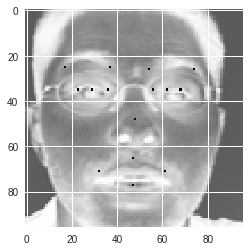

In [43]:
show_results(0)

Ypred [[62.605263 35.61542  31.366875 38.864452 56.04362  37.07295  68.70234
  36.330338 36.962185 39.06367  24.812944 40.415375 53.152843 30.652819
  72.28075  29.155434 36.90937  32.299854 20.168125 34.630276 46.80364
  50.90997  62.59556  72.799355 35.196667 74.82428  47.943836 69.799484
  48.612057 75.39173 ]]


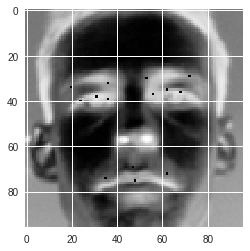

In [44]:
show_results(3)

Ypred [[64.7211   34.26323  30.277803 32.07153  58.15803  34.926525 70.17907
  36.043    36.330406 33.345222 23.968323 32.663082 58.65563  28.050444
  76.014114 27.94094  38.62645  26.813477 20.838562 23.221216 46.81272
  46.41903  56.864067 68.928795 31.102646 66.93365  44.450356 63.545246
  44.0953   71.3451  ]]


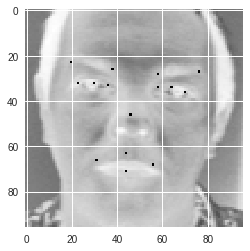

In [46]:
show_results(15)

# The Prediction Accuracy is less.

In [47]:
model.load_weights("/gdrive/My Drive/all/Error_09259.hd5")

model.fit(Xtrain, Ytrain, epochs=3)

Epoch 1/3
2140/2140 [==============================] - 928s 434ms/step - loss: 1.5152 - mean_absolute_error: 0.9360
Epoch 2/3
2140/2140 [==============================] - 938s 438ms/step - loss: 1.3188 - mean_absolute_error: 0.8708
Epoch 3/3
2140/2140 [==============================] - 935s 437ms/step - loss: 1.2838 - mean_absolute_error: 0.8681


In [0]:
model.save_weights("/gdrive/My Drive/all/Error_08681.hd5")

Ypred [[63.074867 36.270294 27.53744  34.96878  57.825245 36.79082  69.26066
  37.298874 34.074883 35.91705  20.994465 35.26601  56.128517 24.256334
  75.61799  26.647985 36.42823  22.431675 13.812361 23.535099 49.779102
  48.79399  61.21554  73.92601  30.857477 73.83291  47.115803 66.0314
  47.070637 84.02543 ]]


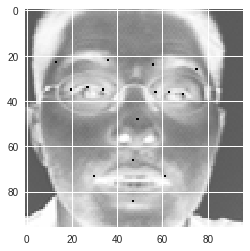

In [48]:
show_results(0)

Ypred [[64.196175 36.826263 28.41582  38.74492  58.064194 37.934475 70.13587
  37.85739  34.632362 39.280785 21.546883 40.097057 56.15544  30.299309
  73.751755 29.465935 36.3023   30.444359 15.399989 33.399456 49.79221
  49.96181  63.44704  75.08431  31.34592  76.613556 47.842438 69.54877
  48.21199  82.50703 ]]


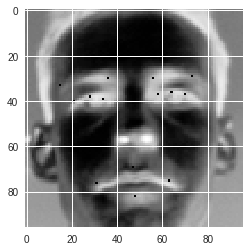

In [49]:
show_results(3)

Ypred [[65.34927  34.92958  27.238668 35.606285 58.439056 35.681496 72.20554
  36.078007 34.497982 36.22253  19.600994 36.617706 55.00874  28.814337
  78.11329  28.91489  38.55516  28.297514 12.888014 29.486923 48.724625
  49.012146 63.057053 73.47429  29.082703 74.30926  46.646008 68.54648
  46.808907 82.97052 ]]


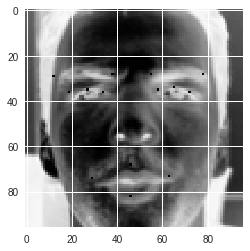

In [51]:
show_results(5)